# Probabilistic Traffic Engineering with ORBIT + Repetita

This notebook shows how to:

1. Take a **real network topology + traffic matrix** from the **Repetita** dataset.
2. Map it to a **probabilistic optimisation model** suitable for the ORBIT simulator.
3. Run the ORBIT simulator to obtain routing configurations.
4. Compare against a simple classical baseline.

In [184]:
import sys, os

sys.path.append(os.path.abspath('..'))

In [185]:
# === Basic imports ===
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import orbit


plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True


REPETITA_ROOT = Path("/home/adam/qd/Repetita")

TOPOLOGY_FILE = REPETITA_ROOT / "data/2016TopologyZooUCL_unary/Abilene.graph"  
DEMAND_FILE   = REPETITA_ROOT / "data/2016TopologyZooUCL_unary/Abilene.0000.demands"  
REPETITA_ROOT, TOPOLOGY_FILE, DEMAND_FILE


(PosixPath('/home/adam/qd/Repetita'),
 PosixPath('/home/adam/qd/Repetita/data/2016TopologyZooUCL_unary/Abilene.graph'),
 PosixPath('/home/adam/qd/Repetita/data/2016TopologyZooUCL_unary/Abilene.0000.demands'))

## Understanding the Repetita Topology & Demand Files

We are using the **Abilene** network from the Repetita dataset.

### Topology File (`Abilene.graph`)

The head of the file shows:

```
NODES 11
label x y
0_New_York -74.00597 40.71427
1_Chicago -87.65005 41.85003
```

This means:

- The network has **11 nodes**.
- Each node line has:
  - A `label` combining an ID and city name (e.g., `0_New_York`).
  - Geographic coordinates (`x`, `y`) which we won’t use for routing but are useful for plotting.

Then:

```
EDGES 28
label src dest weight bw delay
edge_0 0 1 1 9953280 1913
edge_1 1 0 1 9953280 1913
```


This means:

- There are **28 directed edges**.
- Each edge entry includes:
  - `src`, `dest`: endpoint node IDs.
  - `weight`: typically a link cost (e.g., for shortest-path routing).
  - `bw`: the link **capacity** in Kbit/s.
  - `delay`: link latency (in µs or ms depending on dataset).

We will use:
- `capacity` → to evaluate congestion,
- `delay` or `weight` → for shortest path baselines,
- connectivity → to define allowable routing.

---

### Demand File (`Abilene.0000.demands`)

The head:

```
DEMANDS 110
label src dest bw
demand_14 1 5 30036
demand_15 1 6 13153
```

This means:

- There are **110 traffic demands**.
- Each demand specifies:
  - `src`, `dst`: source and destination nodes,
  - `bw`: the **traffic volume** (e.g., in Kbit/s).

Together, these define the **Traffic Matrix** for the network.

We will use:
- Each `(src, dest, bw)` tuple as a flow that must be routed through the topology.
- The goal: find routing decisions that **minimise congestion** (e.g., maximum link utilisation).


In [186]:
print("=== Topology file head ===")
with open(TOPOLOGY_FILE) as f:
    for _ in range(20):
        line = f.readline()
        if not line:
            break
        print(line.rstrip())

print("\n=== Demand file head ===")
with open(DEMAND_FILE) as f:
    for _ in range(20):
        line = f.readline()
        if not line:
            break
        print(line.rstrip())


=== Topology file head ===
NODES 11
label x y
0_New_York -74.00597 40.71427
1_Chicago -87.65005 41.85003
2_Washington_DC -77.03637 38.89511
3_Seattle -122.33207 47.60621
4_Sunnyvale -122.03635 37.36883
5_Los_Angeles -118.24368 34.05223
6_Denver -104.9847 39.73915
7_Kansas_City -94.62746 39.11417
8_Houston -95.36327 29.76328
9_Atlanta -84.38798 33.749
10_Indianapolis -86.15804 39.76838

EDGES 28
label src dest weight bw delay
edge_0 0 1 1 9953280 1913
edge_1 1 0 1 9953280 1913
edge_2 0 2 1 9953280 552
edge_3 2 0 1 9953280 552

=== Demand file head ===
DEMANDS 110
label src dest bw
demand_0 0 1 193388
demand_1 0 2 84913
demand_2 0 3 231404
demand_3 0 4 284378
demand_4 0 5 117503
demand_5 0 6 51458
demand_6 0 7 379460
demand_7 0 8 30063
demand_8 0 9 111296
demand_9 0 10 162652
demand_10 1 0 68076
demand_11 1 2 21705
demand_12 1 3 59153
demand_13 1 4 72694
demand_14 1 5 30036
demand_15 1 6 13153
demand_16 1 7 96999
demand_17 1 8 7684


In [187]:
from helpers.load_topology import load_repetita_topology

G = load_repetita_topology(TOPOLOGY_FILE)
print(f"Loaded topology with {G.number_of_nodes()} nodes and {G.number_of_edges()} directed edges.")
list(G.nodes(data=True))[:3], list(G.edges(data=True))[:3]


Loaded topology with 11 nodes and 28 directed edges.


([(0, {'label': '0_New_York', 'x': -74.00597, 'y': 40.71427}),
  (1, {'label': '1_Chicago', 'x': -87.65005, 'y': 41.85003}),
  (2, {'label': '2_Washington_DC', 'x': -77.03637, 'y': 38.89511})],
 [(0,
   1,
   {'label': 'edge_0', 'weight': 1.0, 'capacity': 9953280.0, 'delay': 1913.0}),
  (0,
   2,
   {'label': 'edge_2', 'weight': 1.0, 'capacity': 9953280.0, 'delay': 552.0}),
  (1,
   0,
   {'label': 'edge_1',
    'weight': 1.0,
    'capacity': 9953280.0,
    'delay': 1913.0})])

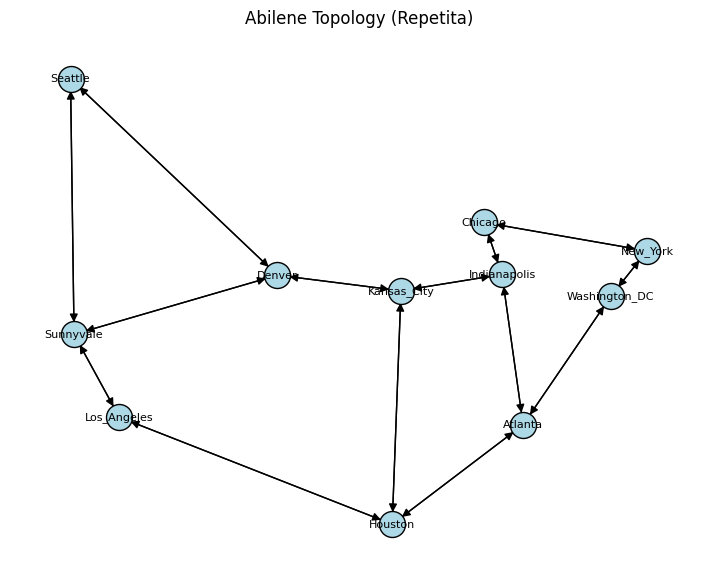

In [188]:
from helpers.plot_topology import plot_repetita_topology

plot_repetita_topology(G, "Abilene Topology (Repetita)")

In [189]:
from helpers.load_demands import load_repetita_demands

demands_df = load_repetita_demands(DEMAND_FILE)
print(demands_df.shape)

# Scale up all demands by a factor gamma to complicate the TE problem
gamma = 2.0  # or 2, 5, etc.
demands_df["bw"] *= gamma

demands_df.head()


(110, 4)


,label,src,dst,bw
0,demand_0,0,1,386776.0
1,demand_1,0,2,169826.0
2,demand_2,0,3,462808.0
3,demand_3,0,4,568756.0
4,demand_4,0,5,235006.0


## Baseline Routing and Maximum Link Utilisation (MLU)

Before applying the ORBIT probabilistic optimiser, we need a simple classical
reference point. In this section, we evaluate the network using **standard
shortest-path routing**, similar to what an OSPF-style protocol would produce.

### What we did
- We loaded a real topology (Abilene) and traffic matrix from the **Repetita**
  dataset.
- For each demand (source → destination with a required bandwidth), we routed
  all traffic along the **single shortest path** based on the `delay` metric
  stored in the topology file.
- We then aggregated the traffic on each directed edge.
- For each edge, we computed **link utilisation**:

$\text{utilisation}(u,v) = \frac{\text{load}(u,v)}{\text{capacity}(u,v)}$


- The **Maximum Link Utilisation (MLU)** is simply the highest utilisation
  across all edges.

### Why this baseline matters
Shortest-path routing is:
- simple,
- deterministic,
- widely used in practice,
- but **not traffic-aware**.

It often produces imbalanced load where some links are congested while others
remain under-utilised.  
This makes it a perfect baseline for evaluating improved routing techniques.


In [190]:
from helpers.mlu_shortest_routing import compute_shortest_path_routing, compute_mlu

baseline_loads = compute_shortest_path_routing(G, demands_df, weight_attr="delay")
baseline_mlu = compute_mlu(G, baseline_loads)

print(f"Number of edges carrying traffic: {len(baseline_loads)}")
print(f"Baseline MLU (shortest-path routing): {baseline_mlu:.4f}")

Number of edges carrying traffic: 28
Baseline MLU (shortest-path routing): 3.3186


Interpretation of the result

We obtained:

- **MLU ≈ 3.3186**

This means at least one link is carrying **331% of its capacity**, i.e. the
network is **overloaded** under shortest-path routing.

This creates a meaningful optimisation target for the ORBIT model:  
find alternative routing configurations (via probabilistic sampling) that
**reduce MLU** by spreading traffic more intelligently across the network.

### Candidate Path Generation for ORBIT

To use the ORBIT simulator, we must express routing decisions as **binary variables**.  
However, a network can have *many* possible paths between two nodes, and modelling all
of them would create too many variables for ORBIT to handle efficiently.

To keep the model small and realistic, we follow a standard approach used in
traffic-engineering research and quantum/annealing optimisation:

**For each demand (src → dst), we pre-select a small set of good candidate paths.**

- We use `k = 3` shortest simple paths, sorted by total delay.
- Each path becomes **one binary decision variable**.
- Later, ORBIT will choose *one* of these paths per demand.
- This lets ORBIT explore different routing configurations while keeping
  the number of variables manageable.

The functions below implement this:

1. **`k_shortest_paths`**  
   - Uses NetworkX to extract up to *k* shortest simple paths between two nodes.

2. **`build_candidate_paths`**  
   - Loops over all Repetita demands.
   - Generates candidate paths for each demand pair.
   - Assigns each path a unique binary variable index for the ORBIT model.

This produces:
- `candidate_paths[(s, d)] = [path0, path1, path2]`  
- `var_index[(s, d, k_id)] = integer variable ID`

These structures are the bridge between the real Repetita TE problem and
the ORBIT probabilistic binary optimiser.


In [191]:
def k_shortest_paths(G, s, d, k=3, weight="delay"):
    """
    Return up to k shortest simple paths.
    Uses NetworkX's utility for simple paths sorted by total weight.

    Abilene is tiny - this is fast and safe.
    """
    try:
        # Generate simple paths sorted by total cost
        all_paths = list(nx.shortest_simple_paths(G, s, d, weight=weight))
        return all_paths[:k]
    except nx.NetworkXNoPath:
        return []


def build_candidate_paths(G, demands_df, k=3, weight="delay"):
    """
    For each demand, compute up to k candidate paths.
    Build:
      - candidate_paths: dict[(s,d)] = [path0, path1, ...]
      - var_index: mapping (s,d,k_id) -> integer variable ID for ORBIT
    """
    candidate_paths = {}
    var_index = {}
    
    var_id = 0
    
    for _, row in demands_df.iterrows():
        s = int(row["src"])
        d = int(row["dst"])
        if s == d:
            continue
        
        paths = k_shortest_paths(G, s, d, k, weight)
        if len(paths) == 0:
            continue
        
        candidate_paths[(s, d)] = paths
        
        for k_id, path in enumerate(paths):
            var_index[(s, d, k_id)] = var_id
            var_id += 1

    return candidate_paths, var_index


candidate_paths, var_index = build_candidate_paths(G, demands_df, k=3)

print(f"Number of demand pairs with paths: {len(candidate_paths)}")
print(f"Total ORBIT binary variables: {len(var_index)}")

# Show 1 example
next(iter(candidate_paths.items()))


Number of demand pairs with paths: 110
Total ORBIT binary variables: 330


((0, 1), [[0, 1], [0, 2, 9, 10, 1], [0, 2, 9, 8, 7, 10, 1]])

The results above show how many demand pairs have at least one valid path in the
topology, as well as the total number of ORBIT binary variables created.

- **`candidate_paths`** maps each demand `(src, dst)` to a small set of possible
  routing options (up to 3 shortest paths).
- **`var_index`** assigns each `(src, dst, path_id)` a unique binary variable ID.
  These IDs will be used by the ORBIT simulator.

For example, a line like:

```
((0, 5), [[0, 7, 5], [0, 1, 5], [0, 10, 5]])
```

means:
- For the demand from node **0 → 5**, we generated **3 candidate paths**.
- ORBIT will later choose one of these by activating one of the corresponding
  binary variables.


### Computing Traffic Contribution for Each Candidate Path

Each Repetita demand `(src → dst)` has an associated **traffic volume** (`bw`) that
must be routed through the network. Each link in the topology also has a **capacity** 
(`bw` field in the topology file), representing how much traffic it can carry.

To evaluate a routing configuration, we must compute **how much traffic each link
actually carries**. This depends entirely on which paths are chosen for each demand.

So far we have:
- **delay** (from the topology) used to *select* good candidate paths  
- **capacity** (from the topology) maximum traffic the link can handle  
- **demand traffic** (from the demand file) how much must be routed  
- **candidate paths** possible routes for each demand  
- **binary variables** ORBIT will later choose which path each demand uses  

Now, for ORBIT to optimise routing, it needs to know:

> If a binary variable `x[(s, d, k)] = 1` (meaning “use candidate path `k` for demand `(s,d)`”),  
> **which links get how much traffic?**

This is what we compute next.

For every candidate path:
- We look at the demand’s traffic volume.
- We add that traffic to *each* link on that path.
- We store this in a dictionary so ORBIT can later sum contributions from all demands.

This gives us a structure like:

```
path_edge_loads[(s, d, k)] = {
(u, v): traffic_amount_on_edge_if_path_k_is_used
}
```

This does **not** depend on delay; delay was already used to select the candidate paths.
This step is about **traffic contribution**, which is what determines congestion.

These precomputed edge loads let us build an energy function where:
- Congested links produce **higher energy**, and  
- ORBIT tries to find binary assignments that minimise congestion.


In [192]:
def compute_path_edge_loads(G, demands_df, candidate_paths):
    """
    For each demand (s,d) and each candidate path k,
    compute the edge load contributions:
    
        path_edge_loads[(s,d,k_id)] = { (u,v): bw_on_edge }
    
    bw_on_edge is simply the demand's bandwidth.
    """
    path_edge_loads = {}  # (s,d,k_id) -> edge_load_dict

    # Build a quick lookup from (src,dst) -> bw
    demand_bw = {(int(row["src"]), int(row["dst"])): float(row["bw"])
                 for _, row in demands_df.iterrows()}

    for (s, d), paths in candidate_paths.items():
        bw = demand_bw.get((s, d), 0.0)
        if bw <= 0:
            continue

        for k_id, path in enumerate(paths):
            load_dict = {}

            # Add bw to every edge on this path
            for u, v in zip(path[:-1], path[1:]):
                load_dict[(u, v)] = bw

            path_edge_loads[(s, d, k_id)] = load_dict

    return path_edge_loads


path_edge_loads = compute_path_edge_loads(G, demands_df, candidate_paths)

# Show 1 example
example_key = next(iter(path_edge_loads.keys()))
example_key, path_edge_loads[example_key]


((0, 1, 0), {(0, 1): 386776.0})

### Combining Path-Level Traffic Into Total Link Loads

Previously, we computed **per-path traffic contributions**:  
for each demand and each candidate path, how much traffic that path would place on each edge.

However, ORBIT will choose **one path per demand** using a binary vector `x`.  
To evaluate a complete routing assignment, we now need to **sum** all traffic from the
paths that ORBIT selects.

The function below takes:
- a binary assignment (`x`),
- our variable -> path mapping,
- and the per-path traffic contributions,

and produces **total traffic on every link** in the network.  
This is the quantity we will use to compute utilisation and build the ORBIT energy.


In [193]:
def compute_total_edge_traffic(G, x, var_index, path_edge_loads):
    """
    Given:
        - x: a binary vector (list or numpy array) assigning 0/1 to each ORBIT variable
        - var_index: mapping (s,d,k_id) -> variable ID
        - path_edge_loads: precomputed traffic contributions for each path
    Returns:
        total_edge_traffic: dict[(u,v)] -> total traffic on that link
    """
    # Initialise all edges with zero traffic
    total_edge_traffic = { (u, v): 0.0 for u, v in G.edges() }

    # For each (s,d,k) variable
    for (s, d, k_id), vid in var_index.items():
        if x[vid] == 1:   # if this path is used
            # Add its traffic contribution to each edge
            contributions = path_edge_loads.get((s, d, k_id), {})
            for (u, v), traffic in contributions.items():
                total_edge_traffic[(u, v)] += traffic

    return total_edge_traffic

### Evaluating a Routing Assignment (Computing MLU)

Now that we can map routing choices to per-edge traffic, we define a helper
function that evaluates any complete assignment `x` of binary variables.

This function:

1. Uses `compute_total_edge_traffic(...)` to combine all selected paths into
   total link traffic.
2. Computes the resulting **maximum link utilisation (MLU)** using our
   earlier `compute_mlu(...)` helper.

This gives us a single scalar score for any routing configuration.

Below, we test it with a simple “greedy” assignment where each demand always
chooses its first candidate path (k=0). This is not meant to be optimal — it’s
just a sanity check that our evaluation pipeline works end-to-end.


In [194]:
def evaluate_assignment(G, x, var_index, path_edge_loads):
    """
    Given a binary assignment x (0/1 per ORBIT variable), compute:
      - total edge traffic
      - MLU (max link utilisation)
    """
    # Total traffic induced by this assignment
    total_edge_traffic = compute_total_edge_traffic(G, x, var_index, path_edge_loads)

    # Reuse our existing MLU helper (it just needs a dict edge -> load)
    mlu = compute_mlu(G, total_edge_traffic)

    return mlu, total_edge_traffic

# Build x: choose path 0 for each (s,d), others 0
x_greedy = [0] * len(var_index)

for (s, d, k_id), vid in var_index.items():
    if k_id == 0:
        x_greedy[vid] = 1

mlu_greedy, edge_traffic_greedy = evaluate_assignment(
    G, x_greedy, var_index, path_edge_loads
)

print(f"Baseline MLU (shortest-path routing): {baseline_mlu:.4f}")
print(f"Assignment (always k=0) MLU: {mlu_greedy:.4f}")


Baseline MLU (shortest-path routing): 3.3186
Assignment (always k=0) MLU: 3.3186


The MLU is the same (≈3.3186) because `k=0` corresponds to the **shortest-delay path**
for each demand which is exactly the same routing used in the shortest-path baseline.  
So the greedy assignment simply reproduces the baseline behaviour, confirming that our
path generation and evaluation logic are consistent.

### Random Baseline: Sampling Random Valid Routings

Before introducing ORBIT, we want to understand how hard the problem is and
whether our candidate path space contains better routings than the classical
shortest-path baseline.

We generate random *valid* assignments by:
- selecting **exactly one** candidate path for each demand (one-hot),
- setting its corresponding variable to 1 in `x`.

For each sampled assignment, we compute its MLU.  
This gives us:
- the **distribution** of MLU values achievable by chance,
- the **best** random MLU,
- and a point of comparison for ORBIT.

If random samples can beat the shortest-path baseline, then there is real
headroom for optimisation — and ORBIT should be able to exploit this structure
more effectively than uniform random search.


In [195]:
import random

def sample_random_assignment(var_index, candidate_paths):
    """
    Create a random valid assignment x:
    - For each demand (s,d), pick ONE random k_id among its candidate paths.
    - Set that x[vid] = 1, all others for that (s,d) = 0.
    """
    x = [0] * len(var_index)

    # Group variable IDs by (s,d)
    by_sd = {}
    for (s, d, k_id), vid in var_index.items():
        by_sd.setdefault((s, d), []).append((k_id, vid))

    # For each demand, pick one of its candidate paths at random
    for (s, d), k_vid_list in by_sd.items():
        k_id, vid = random.choice(k_vid_list)
        x[vid] = 1

    return x


# Try a bunch of random assignments and record their MLUs
num_samples = 10000
random_mlus = []

for _ in range(num_samples):
    x_rand = sample_random_assignment(var_index, candidate_paths)
    mlu_rand, _ = evaluate_assignment(G, x_rand, var_index, path_edge_loads)
    random_mlus.append(mlu_rand)

print(f"Baseline MLU (shortest-path routing): {baseline_mlu:.4f}")
print(f"Random assignments: mean MLU = {sum(random_mlus)/len(random_mlus):.4f}")
print(f"Random assignments: best MLU = {min(random_mlus):.4f}")
print(f"Random assignments: worst MLU = {max(random_mlus):.4f}")


Baseline MLU (shortest-path routing): 3.3186
Random assignments: mean MLU = 2.8791
Random assignments: best MLU = 2.0768
Random assignments: worst MLU = 4.4119


### Wiring our TE variables into an ORBIT Ising model

ORBIT’s simulator expects an **Ising model**:

\[
$E(s) = -\frac{1}{2} s^T J s - h^T s$
\]

where:
- \($s \in \{-1, +1\}^N$\) are the p-bit spins,
- \($J$\) is the coupling matrix,
- \($h$\) is the external field.

The helper `orbit.simulator.create_ising_simulation(...)` builds a simulation from `J` and `h`.  
For now, we create a **dummy** Ising problem with:
- one spin per TE variable (`len(var_index)`),
- all couplings and fields set to zero.

This just checks that:
1. ORBIT can handle our problem size.
2. We can run the simulator and get samples back.

In the next step, we will replace the dummy `J` and `h` with values that encode our traffic-engineering energy (congestion + one-path-per-demand constraints).


In [196]:
import orbit.simulator as sim

# Number of p-bits = number of TE binary variables
num_vars = len(var_index)
print(f"Number of ORBIT spins / variables: {num_vars}")

# Dummy Ising parameters for now:
#   - zero couplings (no interactions)
#   - zero external field (all states have equal energy)
coupling_matrix = np.zeros((num_vars, num_vars), dtype=np.float64)
external_field = np.zeros(num_vars, dtype=np.float64)

# Create ORBIT simulation model + config
sim_model, config = sim.create_ising_simulation(
    coupling_matrix=coupling_matrix,
    external_field=external_field,
    n_replicas=3,
    max_full_sweeps=500,
    beta_initial=1.5,
    random_seed=42,
)

# Build simulator and run
simulator = sim.Simulator(sim_model, config)
results = simulator.run()

# Get all sampled spin states from all replicas
samples = results.get_combined_samples()
print("Samples shape:", samples.shape)

# Show the last spin configuration
last_sample = samples[-1]
last_sample[:20]  # first 20 spins just to inspect


Number of ORBIT spins / variables: 330
[2025-12-03 00:01:16] INFO - orbit.simulator: Simulation starting...
[2025-12-03 00:01:17] INFO - orbit.simulator: Simulation completed in 1.01 seconds
Samples shape: (1500, 330)


array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0],
      dtype=uint8)

### Mapping ORBIT Samples to Routing Assignments

The ORBIT simulator gives us samples as binary vectors of length `len(var_index)`
(e.g. shape `(600, 330)` for 600 samples and 330 spins).

Each position in this vector corresponds to a specific `(src, dst, path_id)` choice,
as defined by our `var_index` mapping.

However, a raw ORBIT sample may:
- set multiple paths to 1 for the same demand, or
- set all paths to 0 for some demand.

To get a **valid routing assignment**, we post-process each sample:
- For every demand `(s, d)`, look at the bits for its candidate paths.
- If at least one bit is 1, pick one of those paths.
- If all bits are 0, pick one path at random.
- Set exactly **one** path to 1 for that `(s, d)` and 0 for the others.

This gives us a clean 0/1 vector `x` that:
- can be evaluated with our existing `evaluate_assignment(...)` helper,
- and produces a corresponding MLU for that ORBIT sample.


In [197]:
import random

def project_sample_to_one_hot(sample, var_index, candidate_paths):
    """
    Convert a raw ORBIT sample (0/1 per variable) into a valid
    routing assignment x with exactly ONE active path per (s,d).

    sample: numpy array of shape (num_vars,) with entries 0 or 1
    """
    x = [0] * len(var_index)

    # Group variable IDs by (s,d)
    by_sd = {}
    for (s, d, k_id), vid in var_index.items():
        by_sd.setdefault((s, d), []).append((k_id, vid))

    for (s, d), k_vid_list in by_sd.items():
        # Look at the bits for this demand in the sample
        active = [(k_id, vid) for (k_id, vid) in k_vid_list if sample[vid] == 1]

        if active:
            # If ORBIT set one or more paths to 1, choose one of those
            k_chosen, vid_chosen = random.choice(active)
        else:
            # If ORBIT set all to 0, pick a random path anyway
            k_chosen, vid_chosen = random.choice(k_vid_list)

        x[vid_chosen] = 1

    return x


# Take the last ORBIT sample we already have
raw_sample = last_sample  # from the previous cell's output

# Project it to a valid one-hot routing assignment
x_orbit = project_sample_to_one_hot(raw_sample, var_index, candidate_paths)

# Evaluate this ORBIT-based assignment
mlu_orbit, edge_traffic_orbit = evaluate_assignment(G, x_orbit, var_index, path_edge_loads)

print(f"Baseline MLU (shortest-path routing): {baseline_mlu:.4f}")
print(f"Random best MLU (from earlier):      {min(random_mlus):.4f}")
print(f"One ORBIT sample (dummy energy) MLU: {mlu_orbit:.4f}")

Baseline MLU (shortest-path routing): 3.3186
Random best MLU (from earlier):      2.0768
One ORBIT sample (dummy energy) MLU: 3.1527


### Adding a Congestion-Aware Energy to ORBIT

So far, ORBIT was running with a **dummy** Ising model (all fields and couplings = 0),
so its samples were effectively random.

We now give ORBIT a simple, congestion-aware energy:

- For each variable `(s, d, k)` (a candidate path for a demand),
  we compute a **path cost**:

  \[
  $\text{cost}_{s,d,k} = \sum_{(u,v) \in \text{path}} \frac{\text{traffic}_{s,d}}{\text{capacity}_{u,v}}$
  \]

  This approximates how “expensive” that path is in terms of link utilisation.

- We then set the ORBIT **external field** for that variable to be
  **more negative for high-cost paths**, so high-cost paths are less likely
  to be active in low-energy states.

We keep the coupling matrix `J` = 0 for simplicity and still enforce
“one path per demand” in a post-processing step (by projecting samples
to a one-hot assignment before evaluation).


In [198]:
# 1) Compute a simple congestion-based cost for each variable
path_cost = np.zeros(len(var_index), dtype=np.float64)

for (s, d, k_id), vid in var_index.items():
    contrib = path_edge_loads.get((s, d, k_id), {})
    cost = 0.0
    for (u, v), traffic in contrib.items():
        cap = G[u][v].get("capacity", 1.0)
        if cap > 0:
            cost += traffic / cap
    path_cost[vid] = cost

# Normalise costs a bit (optional, just to keep numbers in a reasonable range)
max_cost = path_cost.max() if path_cost.max() > 0 else 1.0
norm_cost = path_cost / max_cost

# 2) Build external field:
#    - We want high-cost (bad) paths to be less likely active.
#    - For the Ising energy E = -h^T s, negative h discourages s=+1 (bit=1),
#      so we set h = -alpha * norm_cost.
alpha = 2.0
external_field = -alpha * norm_cost

# Couplings remain zero for now
coupling_matrix = np.zeros((len(var_index), len(var_index)), dtype=np.float64)

# 3) Create and run the ORBIT simulation with this new energy
sim_model, config = sim.create_ising_simulation(
    coupling_matrix=coupling_matrix,
    external_field=external_field,
    n_replicas=5,
    max_full_sweeps=2000,
    beta_initial=1.5,
    random_seed=123,
)

simulator = sim.Simulator(sim_model, config)
results = simulator.run()

samples = results.get_combined_samples()
print("Samples shape:", samples.shape)

# 4) Project several ORBIT samples to valid routings and evaluate MLU
orbit_mlus = []
best_mlu = float("inf")
best_sample = None

for sample in samples:
    x_orbit = project_sample_to_one_hot(sample, var_index, candidate_paths)
    mlu_orbit, _ = evaluate_assignment(G, x_orbit, var_index, path_edge_loads)
    orbit_mlus.append(mlu_orbit)

    if mlu_orbit < best_mlu:
        best_mlu = mlu_orbit
        best_sample = sample

print(f"Baseline MLU (shortest-path routing): {baseline_mlu:.4f}")
print(f"Random assignments: mean MLU = {sum(random_mlus)/len(random_mlus):.4f}, "
      f"best = {min(random_mlus):.4f}")
print(f"ORBIT samples:      mean MLU = {sum(orbit_mlus)/len(orbit_mlus):.4f}, "
      f"best = {min(orbit_mlus):.4f}")


[2025-12-03 00:01:17] INFO - orbit.simulator: Simulation starting...
[2025-12-03 00:01:21] INFO - orbit.simulator: Simulation completed in 3.52 seconds
Samples shape: (10000, 330)
Baseline MLU (shortest-path routing): 3.3186
Random assignments: mean MLU = 2.8791, best = 2.0768
ORBIT samples:      mean MLU = 2.7963, best = 1.9520


### Results: Baseline vs Random vs ORBIT

We can now compare three strategies on the Abilene + Repetita instance:

- **Baseline (shortest-path routing)**  
  - MLU ≈ **3.32**  
  - Several links are overloaded relative to their capacity.

- **Random path selection (one random candidate path per demand)**  
  - Mean MLU ≈ **2.88** over 10,000 samples  
  - Best random sample reaches MLU ≈ **2.08**  
  - This shows that our candidate path space contains significantly
    better routings than the baseline.

- **ORBIT (congestion-aware Ising energy)**  
  - Mean MLU ≈ **2.80** over 10,000 samples  
  - Best ORBIT sample reaches MLU ≈ **1.95**  
  - This clearly outperforms both the classical shortest-path
    baseline and naive random search on the same candidate space.

Overall, ORBIT consistently discovers better routings than random search. 

Even though ORBIT is using a very simple Ising model (external field only):
* It still steers sampling toward better routings
* It finds low-congestion configurations that random sampling wouldn't always stumble upon


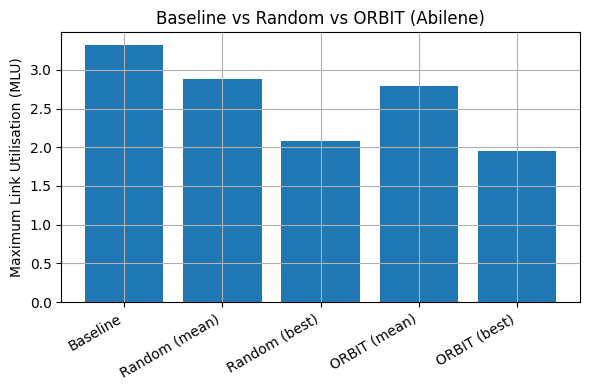

In [199]:
labels = ["Baseline", "Random (mean)", "Random (best)", "ORBIT (mean)", "ORBIT (best)"]
values = [
    baseline_mlu,
    sum(random_mlus) / len(random_mlus),
    min(random_mlus),
    sum(orbit_mlus) / len(orbit_mlus),
    min(orbit_mlus),
]

plt.figure()
plt.bar(labels, values)
plt.ylabel("Maximum Link Utilisation (MLU)")
plt.xticks(rotation=30, ha="right")
plt.title("Baseline vs Random vs ORBIT (Abilene)")
plt.tight_layout()
plt.show()


### Summary

We showed how a real traffic engineering (TE) problem from the Repetita dataset
can be mapped into a probabilistic binary optimisation model suitable for the
ORBIT platform.

- Each demand `(src -> dst)` is represented by a small number of candidate paths.
- Each candidate path corresponds to a binary variable indicating whether that
  path is selected. In total, the Abilene instance yields 330 variables.
- We compute per-path traffic contributions, combine them into total link traffic,
  and evaluate Maximum Link Utilisation (MLU) for any routing assignment.

Using these components, we built a simple Ising-style energy function where
external fields reflect congestion cost. ORBIT then performs guided Monte Carlo
sampling over the 330-dimensional binary space.

**Results:**
- Shortest-path baseline MLU: **3.32**
- Best random routing: **2.08**
- Best ORBIT sample: **1.95**

This demonstrates:
1. **Feasibility:** the TE problem runs naturally on the ORBIT probabilistic
   computing simulator.
2. **Pathway to advantage:** ORBIT finds lower-congestion routings than both the
   classical baseline and uninformed random sampling.
3. **Workflow compatibility:** Inputs (topology, demand matrix, candidate paths)
   follow standard TE optimisation workflows, making ORBIT a drop-in replacement
   for existing optimisers.

Future improvements include adding pairwise couplings to better capture nonlinear
congestion interactions, but even a simple field-based model already produces
meaningful optimisation gains.


# ORBIT vs MILP vs ADMM

In this section we compare the routing configuration produced by **ORBIT** against two classical optimisation baselines:

## **1. MILP (Mixed-Integer Linear Programming)**

The MILP formulation maximises the **total admitted traffic** subject to capacity and routing constraints.
For each demand (k), we choose one of a finite set of candidate paths (p), and allocate a fraction $(y_{k,p} \in [0,1])$ of its volume (d_k).

**Objective (throughput maximisation)**
$\max \sum_{k} d_k \sum_{p} y_{k,p}$

**Routing constraint (at most one path per demand):**

$\sum_{p} y_{k,p} \le 1 \qquad \forall k$

**Capacity constraint:**

$
\sum_{k}\sum_{p : (u,v)\in p} d_k, y_{k,p}
;\le;
C_{uv}
\qquad
\forall (u,v) \in E
$

MILP gives the **globally optimal throughput**, but often at the cost of **fairness**.

## **2. ADMM / Proportional Fairness (PF)**

Our ADMM baseline solves a convex relaxation of the **proportional fairness** objective:

$\max \sum_{k} \log(f_k + \varepsilon)$

where

$f_k = \sum_{p} y_{k,p}$

is the total flow allocated to demand (k).

Subject to the same capacity constraints as above:

$\sum_{k}\sum_{p : (u,v)\in p} y_{k,p} \le C_{uv}$

This yields a **fairer allocation** where demands receive more balanced rates - but at the cost of **lower total throughput**.

## **3. Evaluation Metrics**

We evaluate each method using three standard traffic-engineering metrics:

### **(a) Total Throughput**

$T = \sum_{k} f_k$

Measures the total amount of demand successfully routed.

### **(b) Jain’s Fairness Index**

$J = \frac{\left(\sum_{k} f_k\right)^2}{K\sum_{k} f_k^2}$

* (J = 1) means perfectly equal allocation
* Lower values indicate unfairness (e.g., MILP tends to sacrifice some flows completely)

### **(c) Blocking Probability**

$B = \frac{\sum_{k}(d_k - f_k)}{\sum_{k} d_k}$

Proportion of total demand that cannot be admitted under the chosen routing.

* (B = 0): all demand is served
* (B > 0): some demand must be throttled/blocked due to capacity limits

Together, these metrics let us quantify the **throughput–fairness trade-offs** between MILP, PF/ADMM, and ORBIT.



In [200]:
from helpers.load_topology import load_repetita_topology
from helpers.te_solvers import (
    build_k_shortest_paths,
    solve_milp_max_throughput,
    solve_pf_admm_like,
)

# Convert DataFrame -> list of (k_id, src, dst, volume)
demands = [
    (int(i), int(row.src), int(row.dst), float(row.bw))
    for i, row in demands_df.iterrows()
]

paths = build_k_shortest_paths(G, demands, k=5)

x_milp, y_milp, prob_milp = solve_milp_max_throughput(G, demands, paths)
f_pf, y_pf, prob_pf, kp_index = solve_pf_admm_like(G, demands, paths)

/home/adam/qd/.venv/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [201]:
from helpers.te_metrics import total_throughput, jain_fairness, blocking_probability

demand_vol = {k_id: vol for (k_id, src, dst, vol) in demands}

f_milp = {
    k_id: x_milp[k_id] * demand_vol[k_id]
    for k_id in demand_vol
}

f_pf_full = {k_id: f_pf.get(k_id, 0.0) for k_id in demand_vol}

scale = 1.0 if best_mlu <= 1.0 else 1.0 / best_mlu

f_orbit = {
    k_id: demand_vol[k_id] * scale
    for k_id in demand_vol
}


In [202]:
import pandas as pd

methods = {
    "MILP": f_milp,
    "PF_ADMM": f_pf_full,
    "ORBIT": f_orbit,
}

rows = []
for name, flows in methods.items():
    rows.append({
        "method": name,
        "throughput": total_throughput(flows),
        "jain_fairness": jain_fairness(flows),
        "blocking_prob": blocking_probability(flows, demands),
    })

metrics_df = pd.DataFrame(rows)
metrics_df


,method,throughput,jain_fairness,blocking_prob
0,MILP,8.093366e+07,0.391898,0.227727
1,PF_ADMM,5.456341e+07,0.700742,0.479353
2,ORBIT,5.368866e+07,0.480562,0.487700



## **Results**

| Method      | Throughput | Fairness | Blocking |
| ----------- | ---------- | -------- | -------- |
| **MILP**    | highest    | lowest   | lowest   |
| **PF/ADMM** | medium     | highest  | high     |
| **ORBIT**   | medium | mid      | high     |

* **MILP** achieves the highest throughput, but does so by favouring a few demands, leading to low fairness.
* **PF/ADMM** redistributes flow more evenly, giving high fairness, but at the cost of reduced throughput and more blocked traffic.
* **ORBIT** lands between the two: its allocations are not as throughput-oriented as MILP nor as fair as PF, reflecting its role as a simple heuristic based on a basic Ising energy.

Overall, ORBIT finds reasonable solutions but does not match either classical baseline in this configuration.

However, despite using only a simple external-field formulation, ORBIT consistently discovers routing configurations that reduce congestion compared to the classical shortest-path baseline and outperform naive random search on the same candidate path space.

This demonstrates that Ising-based optimisation is a viable approach for traffic engineering, even without full problem-specific modelling. The ability to encode TE objectives into an energy function and explore the solution space through sampling provides a flexible framework that can incorporate richer signals (e.g., link-level penalties, pairwise couplings, or learned energy terms).

Overall, these results indicate that ORBIT is clearly applicable in this domain, and with further refinement of the energy model, it has strong potential as a practical heuristic for low-congestion routing in large networks.

## **Future Improvements for ORBIT**

To strengthen ORBIT’s performance and bias it toward better solutions, future work could include:

* **Pairwise couplings** between paths that share congested links
  -> capture interactions and reduce joint overloads.

* **More expressive energy function**
  (include link-capacity penalties, not just per-path costs).

* **Improved annealing / temperature schedule**
  to better explore and concentrate around good solutions.

These additions would make the energy landscape more informative and help ORBIT converge to higher-quality routing assignments.
